# UrbanSound8k Dataset Exploration, Display & Classification using Neural Network models

Parte 3. Incluye el Método 3. Esta parte puede ejecutarse de forma independiente
En lugar de hacer la clasificación de las muestras utilizando una red neuronal ya preentrenada, se realiza otra "feature estraction" que esta vez toma como base los parámtros MFCC que devuleve la función librosa.load, de los audios. Se programa una red neuronal, se entrena, y se obtinen las gráficas de accuracy, de loss, y la matriz de confusión, y finlamente, se compara el restultado con las redes preentrenadas de la parte 1 de la práctica y la red "propia" de la parte 2. (Esta parte puede ejecutarse de forma independiente)

## Install Packages



In [ ]:
import os
import time
import librosa 
import zipfile
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image
import librosa as lb

In [ ]:
from tqdm import tqdm #Para crear progress bars
from pathlib import Path

In [ ]:
import mutagen
import mutagen.wave

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Data Reading 

<a href="https://urbansounddataset.weebly.com/urbansound8k.html">Link to data for downloading</a>



In [ ]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [ ]:
#cargamos los datos en nuestro dataset usando la función anterior
dataset_df = create_dataset_df('UrbanSound8K.csv')

In [ ]:
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/content/drive/MyDrive/Colab Notebooks/UrbanSo...
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/content/drive/MyDrive/Colab Notebooks/UrbanSo...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/content/drive/MyDrive/Colab Notebooks/UrbanSo...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/content/drive/MyDrive/Colab Notebooks/UrbanSo...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/content/drive/MyDrive/Colab Notebooks/UrbanSo...


In [ ]:
dataset_df.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [ ]:
#UrbanSound8k.csv
#
#This file contains meta-data information about every audio file in the dataset. This includes:
#
#* slice_file_name: 
#The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
#[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
#[classID] = a numeric identifier of the sound class (see description of classID below for further details)
#[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
#[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence
#
#* fsID:
#The Freesound ID of the recording from which this excerpt (slice) is taken
#
#* start
#The start time of the slice in the original Freesound recording
#
#* end:
#The end time of slice in the original Freesound recording
#
#* salience:
#A (subjective) salience rating of the sound. 1 = foreground, 2 = background.
#
#* fold:
#The fold number (1-10) to which this file has been allocated.
#
#* classID:
#A numeric identifier of the sound class:
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music
#
#* class:
#The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music

Toda esta parte se encuentra en el script de la primera parte de la práctica. Que contiene todo el análisis cuantitativo, visualizaciones, y método de Machine Learning para los métodos 1 (clase) y 2 (Uso del espectograma-Mel como features).





## Data Stadistics
Queremos ver cómo se grabaron los archivos de audio y cómo se distribuyen las diferentes clases.

Las clases son: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music.
Podemos observar todas las clases excepto car_horn, gun_shot y siren que tienen 1000 muestras. Podríamos explorar opciones para incluir pesos de clase en la función de pérdida o sobremuestreo si vemos que las clases infrarrepresentadas no están siendo clasificadas tan bien como el resto.  Pero para efectos prácticos de esta práctica consideramos que estan bien balanceadas.

Balanceado excepto para las clases:  `gun_shot` y `car_horn`. El resto de metadatos es muy similar para todas las clase

# SEGUNDA y TERCERA PARTE: EXTRACCIÓN DE CARACTERÍSTICAS, Y MÉTODO DE CLASIFICACIÓN (Red Neuronal).

Modelo 3 -Usando como features: parámetro HFCCs

Vimos anteriormente que otra forma usual de abordar el problema de la clasificación de sonidos, como forma alternativa al uso del espectograma es hacerlo a partir de los coeficientes MFCCs, utilizando estos como features.
Repetiremos el ejercicio bajo este punto de vista y compararemos resutados.

## Data Prepocessing

In [ ]:
#nos vamos a quedar con los audios de < de 4seg.
audios_short = dataset_df[dataset_df['duration']!=4]['filepath']
print(f"Número de audios con una duración menor a 4s: {len(audios_short)}")

Número de audios con una duración menor a 4s: 1676


In [ ]:
for i in audios_short:
    y, sr = librosa.load(i)
    while len(y)<88200:
        y = np.concatenate((y, y))
        y = y[0:88200]

KeyboardInterrupt: ignored

In [ ]:
##### MÉTODO 3.Uso de MFCCs como features

In [ ]:
import IPython.display as ipd

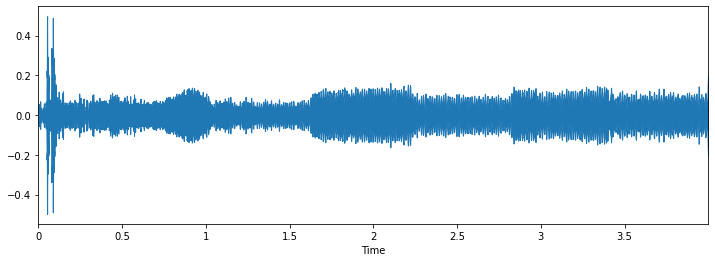

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/audio/fold1/46918-5-0-0.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

In [ ]:
#Estructura de ficheros wave
#La estructura de los ficheros wave se organiza de la siguiente manera:

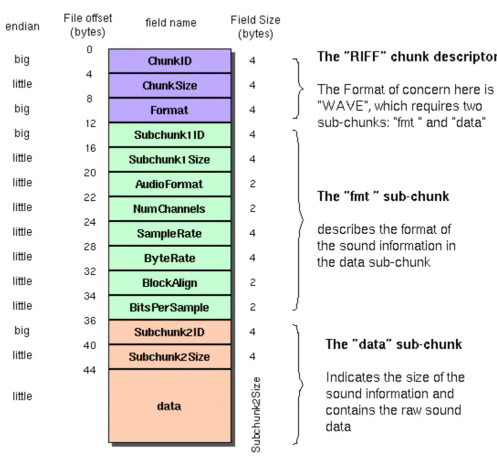

In [ ]:
#Para extraer las 3 propiedades concretas que necesitamos de los ficheros wave, utilizaremos el siguiente código:
#Canales de audio: Vemos que existen canales en «mono» u otros en «estereo», por ello la siguiente variable nos muestra dos salidas diferentes.
#Frecuencia de muestreo: Vemos que existe una amplia gama de frecuencias de muestreo y esto hace que los datos no sean comparables.
#Profundidad de bits: También podemos ver que existen diferentes profundidades dependiendo de la muestra.

In [ ]:
import struct

class WavFileHelper():
    def read_file_properties(self, filename):
        wave_file = open(filename, "rb")

#riff son los bytes 2 a 12
#fmt son los bytes 12 a 36
        riff = wave_file.read(12)
        fmt = wave_file.read(36)

#leemos num de canales: 22 a 24 de wav, o 10 a 12 de fmt
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

#leemos sample date: 24 a 28 de wav, o 12 a 16 de fmt
        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I", sample_rate_string)[0]

#leemos bits per sample: 34 a 36 de wav, o 22 a 24 de fmt
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H", bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [ ]:
wavfilehelper = WavFileHelper()
data = wavfilehelper.read_file_properties('/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/audio/fold5/6508-9-1-0.wav')
print(data)

(2, 44100, 16)


In [ ]:
#tenemos una clase data que para cada audio contiene(num_canales, sample_rate, bits_per_sample)

In [ ]:
# Set the path to the full UrbanSound dataset 
fulldatasetpath = '/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/audio/'

In [ ]:
# Set the path to metadata.
metadata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head(10)
print(metadata.classID.value_counts())

3    1000
2    1000
0    1000
9    1000
5    1000
7    1000
4    1000
8     929
1     429
6     374
Name: classID, dtype: int64


In [ ]:
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

In [ ]:
# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [ ]:
audiodf

,num_channels,sample_rate,bit_depth
0,2,44100,16
1,2,44100,16
2,2,44100,16
3,2,44100,16
4,2,44100,16
...,...,...,...
8727,2,44100,16
8728,2,44100,16
8729,2,44100,16
8730,2,44100,16


In [ ]:
print(audiodf.num_channels.value_counts(normalize=True))

2    0.915369
1    0.084631
Name: num_channels, dtype: float64


In [ ]:
print(audiodf.sample_rate.value_counts(normalize=True))

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


In [ ]:
print(audiodf.bit_depth.value_counts(normalize=True))

16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: bit_depth, dtype: float64


In [ ]:
#Después de calcular las propiedades vamos a analizarlas individualmente:
#Canales de audio: Vemos que existen canales en «mono» u otros en «estereo», por ello la siguiente variable nos muestra dos salidas diferentes.
#Frecuencia de muestreo: Vemos que existe una amplia gama de frecuencias de muestreo y esto hace que los datos no sean comparables.
#Profundidad de bits: También podemos ver que existen diferentes profundidades dependiendo de la muestra. Bits per sample. Bit por muestra

In [ ]:
#Estandarización de datos
#Fijar una ventana deslizante con duración de 2 segundos y una superposición de 1 Segundo. ->> Nosotros deberíamos a 4 seg
#Fijar un número de bandas de frecuencia, si el número es demasiado corto perdemos resolución y si es demasiado alto tendremos muchas bandas vacías.
#No había código para esto...

In [ ]:
#Extraer características
#Posteriormente extraemos las características propias de cada imagen que nos van a permitir entrenar el modelo.

In [ ]:
#Los espectrogramas son una técnica útil para visualizar el espectro de frecuencias de un sonido y cómo varían durante un período de tiempo muy corto. 
#Utilizaremos una técnica similar conocida como Mel-Frequency Cepstral Coefficients (MFCC).

#Para cada archivo de audio en el conjunto de datos, extraeremos un MFCC (lo que significa que tenemos una representación de imagen para cada muestra de audio)
#y lo almacenaremos en un Panda Dataframe junto con su etiqueta de clasificación. 
#Para esto, utilizaremos la función mfcc() de Librosa, que genera un MFCC a partir de datos de audio de series temporales.

In [ ]:
import numpy as np

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)  #n_mFcc: number of MFCCs to return
        mfccsscaled = np.mean(mfccs.T,axis=0)   #sacamos su media
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccsscaled

In [ ]:
# Load various imports 
import pandas as pd
import os
import librosa

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["classID"]  #leemos la clase
    data = extract_features(file_name) #leemos el valor mcfcdsscaled
    
    features.append([data, class_label]) #unimos ambas

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label']) #lo convertimos en una fila de nuestro dataframe

print('Finished feature extraction from ', len(featuresdf), ' files') #nos cuenta el total de filas procesadas

Finished feature extraction from  8732  files


In [ ]:
features = featuresdf.loc[1]
print( list(features) )

[array([-4.2468677e+02,  1.1056227e+02, -5.4148235e+01,  6.2010738e+01,
       -7.0951545e-01,  1.8157396e+01,  1.4451565e+00,  1.1161132e+01,
       -1.7058903e+00,  1.2360451e+01, -1.1055477e+01,  2.0736568e+01,
       -8.9631729e+00,  1.2854286e+01,  6.1885095e-01,  6.2307854e+00,
       -2.0106168e+00,  1.0296951e+01, -5.1904492e+00,  5.7075348e+00,
       -1.7615210e+00,  7.6622715e+00, -1.3133461e+00,  7.4455166e+00,
       -7.6258445e-01,  4.9681205e-01, -3.7199671e+00,  6.4680380e-01,
       -5.6421432e+00,  4.4832695e-01, -6.9735932e-01,  1.6416031e+00,
       -7.8456962e-01, -4.1275598e-02,  3.9597638e-02, -9.4418697e-02,
       -1.6568049e+00,  6.1740863e-01, -6.8497407e-01,  5.7151443e-01],
      dtype=float32), 2]


In [ ]:
# cada línea de featuresdf, contiene un array con las 40 muestras MFCCs escaladas y la clase

In [ ]:
#Convertir los datos y etiquetas
#Para transformar los datos categóricos a numéricos usaremos «LabelEncoder» y así conseguiremos que el modelo sea capaz de entenderlos >>  de categorico a númeroco

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())     #X -> array con las MFCCs_escalados
y = np.array(featuresdf.class_label.tolist()) #y -> array con las clases

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

In [ ]:
print(X)
print(y)
print(yy)

[[-2.15793015e+02  7.16661224e+01 -1.31813766e+02 ... -1.68275905e+00
  -8.85858238e-01  3.54388624e-01]
 [-4.24686768e+02  1.10562271e+02 -5.41482353e+01 ...  6.17408633e-01
  -6.84974074e-01  5.71514428e-01]
 [-4.59564667e+02  1.22800354e+02 -4.79247093e+01 ...  2.22541404e+00
   1.54661798e+00 -8.36315691e-01]
 ...
 [-3.04613159e+02  1.12619904e+02 -4.71619453e+01 ... -3.03358078e+00
   2.71057296e+00  7.67189503e+00]
 [-3.44714233e+02  1.26758141e+02 -5.61771698e+01 ... -7.80225849e+00
  -1.77907360e+00  5.83541918e+00]
 [-3.15933838e+02  9.56758881e+01 -3.80477676e+01 ...  5.77580512e-01
  -1.14637651e+01 -5.96535349e+00]]
[3 2 2 ... 1 1 1]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [ ]:
#Dividir los datos en entrenamiento y test
#Dividimos el conjunto de datos en dos bloques (80% y 20%) y de ellos sacamos valores de X y de Y

In [ ]:
## 2.3	Generad los espectrogramas para todo el dataset y guardároslo en disco. 
#Se recomienda el uso de ficheros HDF5. 
#Tened en cuenta que para la clasificación vamos a utilizar redes neuronales que esperan entradas de 224x224, no es necesario que guardéis más píxeles. . 

In [ ]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [ ]:
x_train.shape

(6985, 40)

In [ ]:
x_test.shape

(1747, 40)

In [ ]:
#saving the data numpy arrays
np.savetxt("train_data_metodo3.csv", x_train, delimiter=",")
np.savetxt("test_data_metodo3.csv", x_test,delimiter=",")
np.savetxt("train_labels_metodo3.csv",y_train,delimiter=",")
np.savetxt("test_labels_metodo3.csv",y_test,delimiter=",")

In [ ]:
#downloading the saved data from colab's server
from google.colab import files

files.download("train_data_metodo3.csv")
files.download("test_data_metodo3.csv")
files.download("train_labels_metodo3.csv")
files.download("test_labels_metodo3.csv")

**3.1 Seleccionad como mínimo una red neuronal y explicad su arquitectura (número de capas, estructura de cada capa, etc.) (Modelo 3)**

In [ ]:
#Construir el modelo
#Construimos una red neuronal mediante un perceptrón multicapa (MLP) usando Keras y un backend de Tensorflow.
#Se plantea un modelo secuencial para que podamos construir el modelo capa por capa.

In [ ]:
## 3.1	Seleccionad como mínimo una red neuronal y explicad su arquitectura (número de capas, estructura de cada capa, etc.). 

Se plantea una arquitectura de modelo simple, compuesta por:

-Capa de entrada con 40 nodos, ya que la función MFCC de extracción de características nos devuelve un conjunto de datos de 1×40

-Capas ocultas de 256 nodos, estas capas tendrán una capa densa con una función de activación de tipo ReLu, (se ha demostrado que esta función de activación funciona bien en redes neuronales). 

También destacar que aplicaremos un valor de Dropout del 50% en nuestras dos primeras capas. Esto excluirá al azar los nodos de cada ciclo de actualización, lo que a su vez da como resultado una red que es capaz de responder mejor a la generalización y es menos probable que se produzca sobreajuste en los datos de entrenamiento.

-Capa de salida de 10 nodos, que coinciden con el número de clasificaciones posibles.

La activación es para nuestra capa de salida una función softmax. Softmax hace que la salida sume 1, por lo que la salida puede interpretarse como probabilidades. El modelo hará su predicción según la opción que tenga la mayor probabilidad



In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

In [ ]:
num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

#capa de entrada
model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#capas ocultlas. Dropout al 50% en las dos primeras capas
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#capa de salida
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
#Compilar el modelo
#Para compilar nuestro modelo, utilizaremos los siguientes tres parámetros:

###Función de pérdida: utilizaremos categorical_crossentropy. Esta es la opción más común para la clasificación. Una puntuación más baja indica que el modelo está funcionando mejor.
###Métricas: utilizaremos la métrica de accuracy que nos permitirá ver la precisión en los datos de validación cuando entrenemos el modelo.
###Optimizador: aquí usaremos adam, que generalmente es un buen optimizador para muchos casos de uso.

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10496     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

**3.2 Entrenad el modelo para clasificar el dataset UrbanSound 8K.  (Modelo 3)**

In [ ]:
##3.2	Entrenad el modelo para clasificar el dataset UrbanSound 8K

In [ ]:
#Entrenar el modelo
#Se empieza probando con un número de épocas bajo y se prueba hasta ver donde alcanza un valor asintótico en el que por más que subamos las épocas no conseguimos que el modelo mejore significativamente.

#Por otro lado, el tamaño del lote debe ser suficientemente bajo, ya que tener un tamaño de lote grande puede reducir la capacidad de generalización del modelo.

In [ ]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
num_epochs = 50  #número de iteraciones de aprendizaje en el entrenamiento
#Después de haber probado el modelo y sacado las gráficas, vimos que a partir de 50 epochs, los valores de accuracy y loss ya se estabilizaban, 
#por lo que usaremos ese valor para ahorrar tiempo de computación
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/UrbanSound8K/audio/fold_prueba/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history =model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
206/219 [===========================>..] - ETA: 0s - loss: 8.9590 - accuracy: 0.1808
Epoch 1: val_loss improved from inf to 2.19585, saving model to /content/drive/MyDrive/Colab Notebooks/UrbanSound8K/audio/fold_prueba/weights.best.basic_mlp.hdf5
219/219 [==============================] - 2s 6ms/step - loss: 8.5904 - accuracy: 0.1812 - val_loss: 2.1959 - val_accuracy: 0.2147
Epoch 2/100
198/219 [==========================>...] - ETA: 0s - loss: 2.2764 - accuracy: 0.2247
Epoch 2: val_loss improved from 2.19585 to 2.06049, saving model to /content/drive/MyDrive/Colab Notebooks/UrbanSound8K/audio/fold_prueba/weights.best.basic_mlp.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 2.2598 - accuracy: 0.2262 - val_loss: 2.0605 - val_accuracy: 0.2782
Epoch 3/100
210/219 [===========================>..] - ETA: 0s - loss: 2.0831 - accuracy: 0.2781
Epoch 3: val_loss improved from 2.06049 to 1.86327, saving model to /content/drive/MyDrive/Colab Notebooks/UrbanSound8K

3.3 Explicad qué valores de hiperparámetros principales habéis utilizado (batch size, learning rate, optimizer, número de epochs) para obtener los resultados. (Modelo 3)

In [ ]:
## 3.3	Explicad qué valores de hiperparámetros principales habéis utilizado (batch size, learning rate, optimizer, número de epochs) para obtener los resultados.

In [ ]:
#Evaluar el modelo
#Finalmente, para determinar la precisión del modelo generado, llamamos a la función evaluate y le pasamos los datos de test que hemos definido previamente.

3.4 Mostrad las gráficas de accuracy de entrenamiento y validación del modelo. Opcionalmente, también podéis mostrar las gráficas de loss. (Modelo 3)

In [ ]:
# Evaluating the model on the testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy Modlo 3 (HFCCs):", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy Modelo 3 (HFCCs) ", score[1])

Training Accuracy Modlo 3 (HFCCs): 0.9279885292053223
Testing Accuracy Modelo 3 (HFCCs)  0.8866628408432007


In [ ]:
result = pd.DataFrame(score)
result.to_csv("UrbanSound8kResults_Modelo_3.csv")

In [ ]:
##3.4 Mostrad las gráficas de accuracy de entrenamiento y validación del modelo. Opcionalmente, también podéis mostrar las gráficas de loss.

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
lista_epoch = np.linspace(1, num_epochs, num_epochs)

fig = go.Figure(layout_yaxis_range=[0,1])
fig.add_trace(go.Scatter(x=lista_epoch, y=history.history['accuracy'], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=lista_epoch, y=history.history['val_accuracy'], mode='lines', name='test'))
fig.update_layout(title='Model accuracy', hovermode="x")
fig.show()

In [ ]:
lista_epoch = np.linspace(1, num_epochs, num_epochs)

fig = go.Figure(layout_yaxis_range=[0,1.5])
fig.add_trace(go.Scatter(x=lista_epoch, y=history.history['loss'], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=lista_epoch, y=history.history['val_loss'], mode='lines', name='test'))
fig.update_layout(title='Model loss', hovermode="x")
fig.show()

**3.5 Mostrad la matriz de confusión obtenida tras la clasificación. Razonad qué clases clasifica mejor o peor. (Modelo 3)**

In [ ]:
##3.5 Mostrad la matriz de confusión obtenida tras la clasificación. Razonad qué clases clasifica mejor o peor.

In [ ]:
# Plot a confusion matrix
from sklearn import metrics
y_pred = model.predict(x_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
# Confusion matrix code (from https://github.com/triagemd/keras-eval/blob/master/keras_eval/visualizer.py)
def plot_confusion_matrix(cm, concepts, normalize=False, show_text=True, fontsize=18, figsize=(16, 12),
                          cmap=plt.cm.coolwarm_r, save_path=None, show_labels=True):
    '''
    Plot confusion matrix provided in 'cm'
    Args:
        cm: Confusion Matrix, square sized numpy array
        concepts: Name of the categories to show
        normalize: If True, normalize values between 0 and ones. Not valid if negative values.
        show_text: If True, display cell values as text. Otherwise only display cell colors.
        fontsize: Size of text
        figsize: Size of figure
        cmap: Color choice
        save_path: If `save_path` specified, save confusion matrix in that location
    Returns: Nothing. Plots confusion matrix
    '''

    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError('Invalid confusion matrix shape, it should be square and ndim=2')

    if cm.shape[0] != len(concepts) or cm.shape[1] != len(concepts):
        raise ValueError('Number of concepts (%i) and dimensions of confusion matrix do not coincide (%i, %i)' %
                         (len(concepts), cm.shape[0], cm.shape[1]))

    plt.rcParams.update({'font.size': fontsize})

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm_normalized

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, vmin=np.min(cm), vmax=np.max(cm), alpha=0.8, cmap=cmap)

    fig.colorbar(cax)
    ax.xaxis.tick_bottom()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')

    if show_labels:
        n_labels = len(concepts)
        ax.set_xticklabels(concepts)
        ax.set_yticklabels(concepts)
        plt.xticks(np.arange(0, n_labels, 1.0), rotation='vertical')
        plt.yticks(np.arange(0, n_labels, 1.0))
    else:
        plt.axis('off')

    if show_text:
        # http://stackoverflow.com/questions/21712047/matplotlib-imshow-matshow-display-values-on-plot
        min_val, max_val = 0, len(concepts)
        ind_array = np.arange(min_val, max_val, 1.0)
        x, y = np.meshgrid(ind_array, ind_array)
        for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
            c = cm[int(x_val), int(y_val)]
            ax.text(y_val, x_val, c, va='center', ha='center')

    if save_path is not None:
        plt.savefig(save_path)

In [ ]:
class_dictionary = {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
classes = [class_dictionary[key] for key in sorted(class_dictionary.keys())]

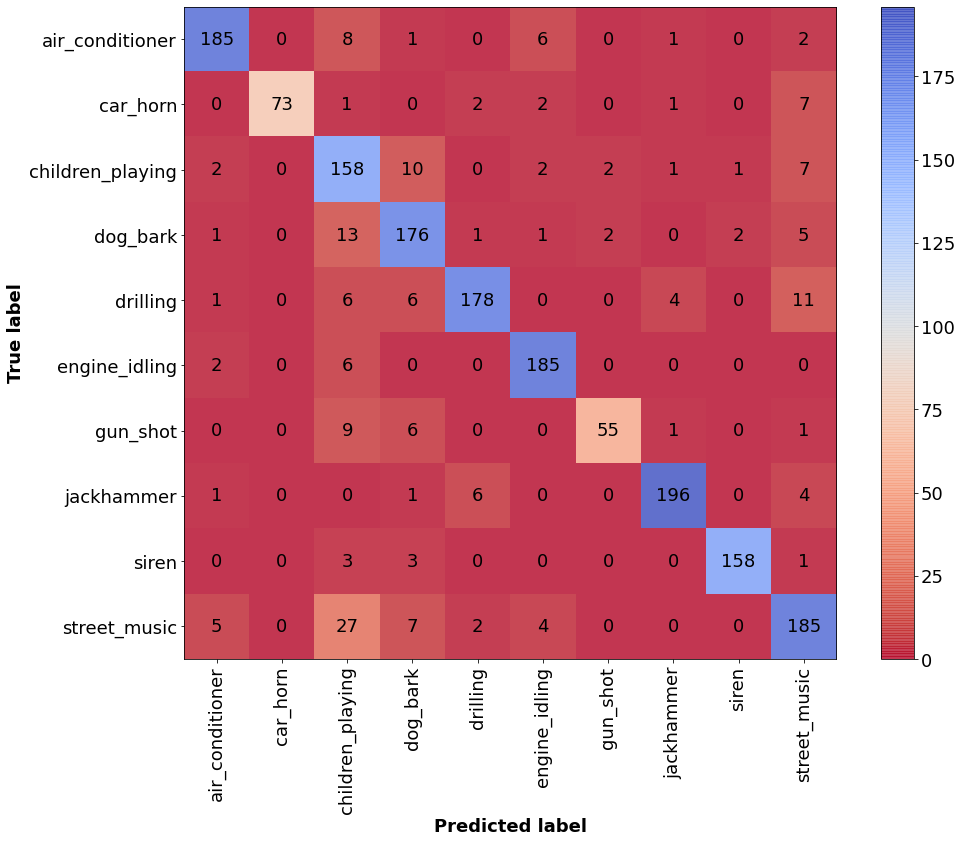

In [ ]:
plot_confusion_matrix(matrix, classes)

In [ ]:
#Fin Parte 2

# Fin de Parte 2